In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import xarray as xr

In [2]:
era5 = xr.open_dataset('data/era5.nc', decode_times=False)
#time is YYYMMDD change ot datetime
# Convert to pandas datetime using the correct format
date_times = pd.to_datetime(era5.date.values.astype(str), format='%Y%m%d')
# Assign the datetime values back to the DataArray if needed
era5 = era5.swap_dims({'date':'T', 'longitude':'X', 'latitude':'Y'})
era5 = era5.assign_coords(T=date_times, X = era5.longitude, Y = era5.latitude)
#remove coordinate date
era5 = era5.drop(['date','latitude', 'longitude', 'expver','number'])

#era5 = era5.sel(T=slice('1979-01-01', '2024-08-01'))

era5['tp'] = era5['tp']*1000*30
data = era5
data['KAUST_precip'] = data['tp'].transpose('T', 'Y', 'X')

C:\Users\emile\AppData\Local\Temp\ipykernel_15536\1684700738.py:9: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  era5 = era5.drop(['date','latitude', 'longitude', 'expver','number'])


In [3]:
#count the number of negative values
print('Number of negative values:', data['KAUST_precip'].where(data['KAUST_precip'] < 0).count().values)

Number of negative values: 0


In [4]:
x_range = data['KAUST_precip'].X.values
y_range = data['KAUST_precip'].Y.values
spi_list = []

for month in range(1, 13): 
    print(f"Processing month: {month}")
    data_month = data['KAUST_precip'].sel(T=data['T.month'] == month)
    #reference_period = data['KAUST_precip'].sel(T=data['T.month']==month).sel(T=slice('1991-01-01', '2020-12-01'))
    #data_month = (data_month - reference_period.mean(dim='T')) #/ (reference_period.std(dim='T') + 1e-6)
    
    T_size = len(data_month['T'])
    spi_storage = np.full((T_size, len(y_range), len(x_range)), np.nan)  # Pre-fill with NaNs

    for i, y in enumerate(y_range):
        for j, x in enumerate(x_range):
            data_grid = data_month.sel(X=x, Y=y)
            # Check if the entire grid is NaN
            if np.isnan(data_grid.values).all():
                # All values remain NaN in spi_storage
                continue
            #if all values are 0
            elif np.all(data_grid.values == 0):
                spi_storage[:, i, j] = 0
            else:
                # Fit pearson type III distribution to the data
                #try:
                a, loc, scale = sp.stats.pearson3.fit(data_grid.values)
                    # Calculate the CDF of the Pearson Type III distribution
                cdf_values = sp.stats.pearson3.cdf(data_grid.values, skew=a, loc=loc, scale=scale)
                q = ((np.sum(data_grid.values == 0)) / len(data_grid.values))
                cdf_values = (cdf_values*(1-q)) + q
                    #replace 0 with 1e-6
                cdf_values = np.where(cdf_values < 0.0001, 0.0001, cdf_values)
                    #replace 1 with 1-1e-6
                cdf_values = np.where(cdf_values > 0.9999, 0.9999, cdf_values)
            
                    # Convert CDF to SPI using the inverse normal distribution (PPF)
                spi_storage[:, i, j] = sp.stats.norm.ppf(cdf_values)
                #except (ValueError, RuntimeError) as e:
                    # If fitting fails, leave Nans in the SPI values
                 #   continue
    # Convert the stored SPI values into an xarray DataArray
    spi_month = xr.DataArray(spi_storage, dims=['T', 'Y', 'X'],
                    coords={'T':data_month['T'] , 'Y': y_range, 'X': x_range})
    spi_list.append(spi_month)

spi = xr.concat(spi_list, dim='T')

Processing month: 1


KeyboardInterrupt: 

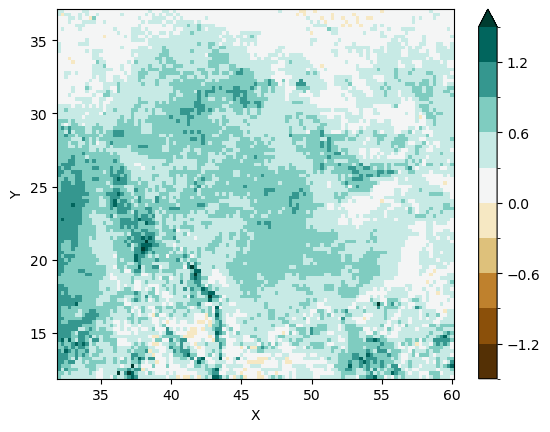

In [33]:
spi.mean(dim='T').plot(vmin=-1.5, vmax=1.5, cmap='BrBG',levels=11)

In [35]:
save = True
if save:
    spi.to_netcdf('data/custom_spi_pearson3_1m.nc')

PermissionError: [Errno 13] Permission denied: 'c:\\git\\KAUST\\data\\custom_spi_gamma_1m.nc'

# experiment

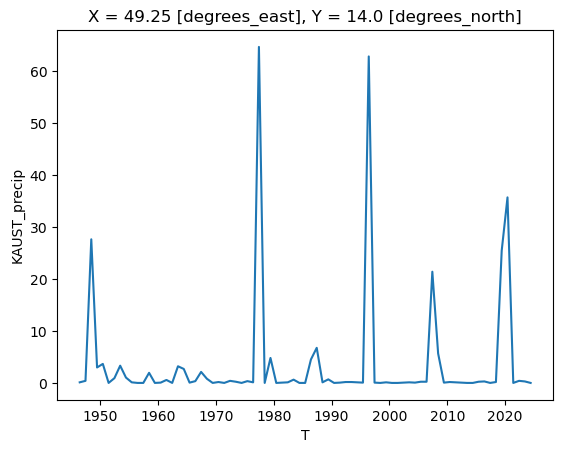

In [36]:
point = data['KAUST_precip'].sel(Y=14, X=49.25, T=data['T.month']==6)
point.plot()

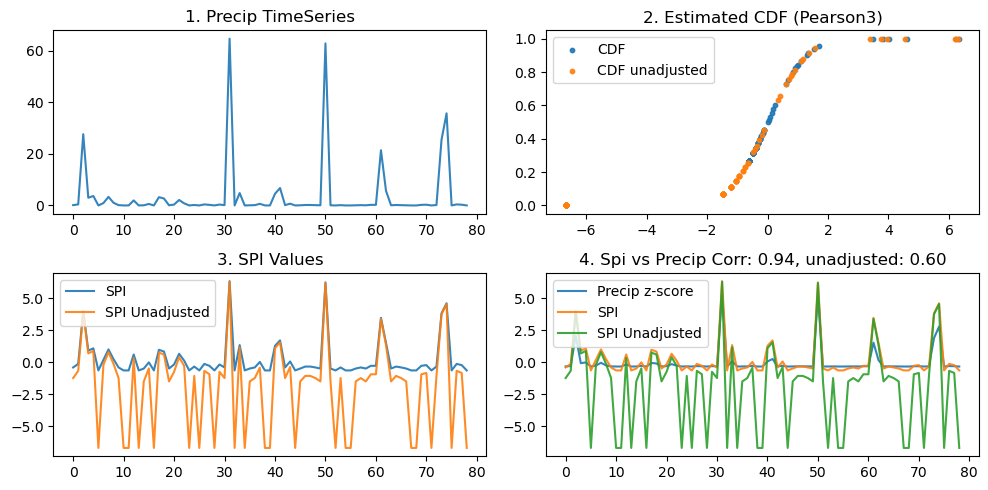

In [89]:

a, loc, scale = sp.stats.pearson3.fit(point.values)
adj_values = sp.stats.pearson3.rvs(skew=a, loc=loc, scale=scale, size=1000)

cdf_values_adj = sp.stats.pearson3.cdf(point.values, skew=a, loc=loc, scale=scale)
q = np.sum(point.values == 0) / len(point.values)
cdf_values_adj = (cdf_values_adj * (1 - q)) + q
#cdf_values_gamma = np.clip(cdf_values_gamma, 0.0001, 0.9999)
spi_values_adj = sp.stats.norm.ppf(cdf_values_adj)

# Simulate from the fitted Pearson3 distribution
a, loc, scale = sp.stats.pearson3.fit(point.values)
unadj_values = sp.stats.pearson3.rvs(skew=a, loc=loc, scale=scale, size=1000)
q = np.sum(point.values == 0) / len(point.values)
cdf_values_unadj = sp.stats.pearson3.cdf(point.values, skew=a, loc=loc, scale=scale)
#cdf_values_pearson = (cdf_values_pearson * (1 - q)) + q
#cdf_values_pearson = np.clip(cdf_values_pearson, 0.0001, 0.9999)
spi_values_unadj = sp.stats.norm.ppf(cdf_values_unadj)

# Plot histograms of gamma and Pearson3 distributions
fig, ax = plt.subplots(2, 2, figsize=(10, 5))

# Plot for gamma distribution
ax[0,0].plot(point.values, alpha=0.9, label="Original Data")
ax[0,0].set_title("1. Precip TimeSeries")

# # Plot for Pearson3 distribution
# ax[0,1].hist(pearson3_values, bins=10, density=True, alpha=0.5, label="Pearson3 Simulated")
# ax[0,1].hist(point.values, bins=10, density=True, alpha=0.5, label="Original Data")
# ax[0,1].set_title("Pearson3 Distribution")
# ax[0,1].legend()

# Plot for gamma SPI values
ax[0,1].scatter(spi_values_adj, cdf_values_adj, alpha=0.9, label="CDF",s=10)
ax[0,1].scatter(spi_values_unadj, cdf_values_unadj, alpha=0.9, label="CDF unadjusted",s=10)
ax[0,1].set_title("2. Estimated CDF (Pearson3)")
ax[0,1].legend()

ax[1,0].plot(spi_values_adj, alpha=0.9, label="SPI")
ax[1,0].plot(spi_values_unadj,alpha=0.9, label="SPI Unadjusted")
ax[1,0].set_title("3. SPI Values")
ax[1,0].legend()

point_values_std = (point.values - point.mean().values) / point.std().values
ax[1,1].plot(point_values_std, alpha=0.9, label="Precip z-score")
ax[1,1].plot(spi_values_adj, alpha=0.9, label="SPI")
ax[1,1].plot(spi_values_unadj,alpha=0.9, label="SPI Unadjusted")

# ax[1,1].scatter(point_values_std, spi_values_adj, alpha=0.9, label="SPI")
# ax[1,1].scatter(point_values_std, spi_values_unadj,alpha=0.9, label="SPI Unadjusted")
#diplsay correlations between SPI and Precip on th efigure
corr_adj = np.corrcoef(spi_values_adj, point.values)[0, 1]
corr_unadj = np.corrcoef(spi_values_unadj, point.values)[0, 1]
ax[1,1].set_title(f"4. Spi vs Precip Corr: {corr_adj:.2f}, unadjusted: {corr_unadj:.2f}") 
ax[1,1].legend()



plt.tight_layout()
